In [8]:
import numpy as np
import h5py as h5

import os

from glob import glob
from tqdm import tqdm

import sys
sys.path.append("../")
sys.path.append("../../ASTERIA/python/")
from sne_bsm import parameterized_flux_from_files, units
from sne_bsm.flux.parametrize_flux import compute_moment, Params, parameterized_flux_from_h5, deserialize
from sne_bsm.flux.sanitize_flux import sanitize_flux
from sne_bsm.likelihood import find_significance_matrix

from tqdm import tqdm

import os
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"

In [3]:
TABULATED_SM_FILE = "./data/sm_flux.h5"
SERIALIZED_SM_FILE = "./data/serialized_sm_flux.h5"

TABULATED_MAJORAN_FILE = "./data/majoran_fluxes.h5"
SERIALIZED_MAJORAN_FILE = "./data/serialized_majoran_fluxes.h5"

TABULATED_HNL_FILE = "./data/magnetic_moment_fluxes.h5"
SERIALIZED_HNL_FILE = "./data/serialized_magnetic_moment_fluxes.h5"

RESULTS_FILE = "./data/results.h5"

In [3]:
infiles = glob("../data/majoron/from_yingying/*.csv")
for infile in tqdm(infiles):
    outfile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    # if os.path.exists(outfile):
    #     continue
    a = np.genfromtxt(infile, delimiter=",")
    # a[:, 2] = a[:, 2] / 6
    a[:, 2] = np.where(a[:, 2]>=0, a[:, 2] / 6, 0)
    np.save(outfile, a)

100%|██████████| 63/63 [32:49<00:00, 31.26s/it]


In [12]:
infiles = glob("../data/magnetic_moment//from_yingying/*.csv")
for infile in tqdm(infiles):
    outfile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    if os.path.exists(outfile):
        continue
    a = np.genfromtxt(infile, delimiter=",")
    # a[:, 2] = a[:, 2] / 6
    a[:, 2] = np.where(a[:, 2]>=0, a[:, 2] / 6, 0)
    np.save(outfile, a)

100%|██████████| 41/41 [00:20<00:00,  1.95it/s]


In [13]:
if not os.path.exists(TABULATED_MAJORAN_FILE):
    with h5.File(TABULATED_MAJORAN_FILE, "w") as _:
        pass

for infile in tqdm(infiles):
    key = infile.split("/")[-1].replace(".csv", "")
    infile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    arr = np.load(infile)
    times = np.sort(np.unique(arr[:, 0])) * units["second"]
    energies = np.sort(np.unique(arr[:, 1])) * units["MeV"]
    fluxes = np.empty(times.shape + energies.shape + (3,),)

    for idx in range(len(times)):
        flux = arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
        flux = np.where(flux >= 0, flux, 0) # Sometimes numerical issues can sneak in to give negative fluxes
        fluxes[idx, :, 0] = flux # nue
        fluxes[idx, :, 1] = flux # nuebar
        fluxes[idx, :, 2] = flux # nux per flavor

    with h5.File(TABULATED_MAJORAN_FILE, "r+") as h5f:

        if key in h5f.keys():
            # del h5f[key]
            continue

        h5f.create_group(key)
        h5f[key].create_dataset("energies", data=energies)
        h5f[key].create_dataset("times", data=times)
        h5f[key].create_dataset("fluxes", data=fluxes)

100%|██████████| 63/63 [02:35<00:00,  2.46s/it]


In [13]:
if not os.path.exists(TABULATED_HNL_FILE):
    with h5.File(TABULATED_HNL_FILE, "w") as _:
        pass

for infile in tqdm(infiles):
    key = infile.split("/")[-1].replace(".csv", "")
    infile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    arr = np.load(infile)
    times = np.sort(np.unique(arr[:, 0])) * units["second"]
    energies = np.sort(np.unique(arr[:, 1])) * units["MeV"]
    fluxes = np.empty(times.shape + energies.shape + (3,),)

    for idx in range(len(times)):
        flux = arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
        flux = np.where(flux >= 0, flux, 0) # Sometimes numerical issues can sneak in to give negative fluxes
        fluxes[idx, :, 0] = flux # nue
        fluxes[idx, :, 1] = flux # nuebar
        fluxes[idx, :, 2] = flux # nux per flavor

    with h5.File(TABULATED_HNL_FILE, "r+") as h5f:

        if key in h5f.keys():
            del h5f[key]
            # continue

        h5f.create_group(key)
        h5f[key].create_dataset("energies", data=energies)
        h5f[key].create_dataset("times", data=times)
        h5f[key].create_dataset("fluxes", data=fluxes)

100%|██████████| 41/41 [00:20<00:00,  1.98it/s]


In [38]:
thin = 10

done_keys = []
if os.path.exists(SERIALIZED_MAJORAN_FILE):
    with h5.File(SERIALIZED_MAJORAN_FILE) as h5f:
        done_keys = list(h5f.keys())

with h5.File(TABULATED_MAJORAN_FILE, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=thin, track=False)
        pflux.serialize(SERIALIZED_MAJORAN_FILE, key)

100%|██████████| 63/63 [00:00<00:00, 2387.26it/s]


In [60]:
key = "sm_flux"
nue_arr = np.genfromtxt("../data//fluxactivenuE.csv", delimiter=",")
nuebar_arr = np.genfromtxt("../data//fluxactivenuEBar.csv", delimiter=",")
nux_arr = np.genfromtxt("../data//fluxactivenuX.csv", delimiter=",")

nue_arr[:, 2] = np.where(nue_arr[:, 2] < 0, 0, nue_arr[:, 2])
nuebar_arr[:, 2] = np.where(nuebar_arr[:, 2] < 0, 0, nuebar_arr[:, 2])
nux_arr[:, 2] = np.where(nux_arr[:, 2] < 0, 0, nux_arr[:, 2])

times = np.sort(np.unique(nue_arr[:, 0])) * units.second
energies = np.sort(np.unique(nue_arr[:, 1])) * units.MeV

# if not np.all(times / units.second==np.sort(np.unique(nuebar_arr[:, 0]))):
#     raise ValueError()
# if not np.all(times / units.second==np.sort(np.unique(nux_arr[:, 0]))):
#     raise ValueError()
# if not np.all(energies / units.MeV==np.sort(np.unique(nuebar_arr[:, 1]))):
#     raise ValueError()
# if not np.all(energies / units.MeV==np.sort(np.unique(nux_arr[:, 1]))):
#     raise ValueError()
    
fluxes = np.empty(times.shape + energies.shape + (3,),)

for idx in range(len(times)):
    nue_flux = nue_arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
    nuebar_flux = nuebar_arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
    nux_flux = nux_arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"] / 4 # Divide by 4 for per flavor
    # Sometimes numerical issues can sneak in to give negative fluxes
    nue_flux = np.where(nue_flux >= 0, nue_flux, 0)
    nuebar_flux = np.where(nuebar_flux >= 0, nuebar_flux, 0)
    nux_flux = np.where(nux_flux >= 0, nux_flux, 0)
    fluxes[idx, :, 0] = nue_flux # nue
    fluxes[idx, :, 1] = nuebar_flux # nuebar
    fluxes[idx, :, 2] = nux_flux # nux per flavor
    
    
if not os.path.exists(TABULATED_SM_FILE):
    with h5.File("./data/sm_flux.h5", "w") as _:
        pass
    
with h5.File(TABULATED_SM_FILE, "r+") as h5f:
        if key in h5f.keys():
            del h5f[key]
            
        h5f.create_group(key)
        h5f[key].create_dataset("energies", data=energies)
        h5f[key].create_dataset("times", data=times)
        h5f[key].create_dataset("fluxes", data=fluxes)

In [62]:
dt = 0.01 * units.second

with h5.File(SERIALIZED_SM_FILE, "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
# sm_t, sm_hits = sm_flux.get_hits(
#     tmax=100 * units["second"],
#     model_file="test.txt",
#     dt=dt,
# )

In [39]:
import h5py as h5
import numpy as np

from glob import glob
from tqdm import tqdm

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
from matplotlib.colors import ListedColormap, to_rgba, to_rgb
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import sys
import os

sys.path.append(os.path.abspath("../../ASTERIA/python/"))
os.environ["ASTERIA"] = os.path.abspath("../../ASTERIA")

sys.path.append("../")
from sne_bsm import parameterized_flux_from_files, units
from sne_bsm.likelihood import find_significance_matrix 
from sne_bsm.flux.parametrize_flux import deserialize

In [105]:
SM_SERIALIZE_FILE = "./data/serialized_sm_flux.h5"
BSM_SERIALIZE_FILE = "./data/serialized_majoran_fluxes_new.h5"
# BSM_SERIALIZE_FILE = "./data/serialized_majoran_fluxes.h5"

MODEL1 = "dphi-dEdt-1MeV-gn10dot2-100s-nf"
MODEL2 = "dphi-dEdt-10MeV-gn10dot8-100s-nf"
MODEL3 = "dphi-dEdt-100MeV-gn11dot7-100s-nf"

MODELS = [
    MODEL1,
    # MODEL2,
    MODEL3,
]

COLORS = [
    "mediumturquoise", # MODEL1
    "dodgerblue", # MODEL2
    "hotpink",
    # "red", # SM
]

LABELS = [
    r"$m_{\phi}=1~\mathrm{MeV}$",
    r"$m_{\phi}=100~\mathrm{MeV}$",
]

In [41]:
with h5.File(SM_SERIALIZE_FILE, "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])

# bsm_fluxes = []

# for model in tqdm(MODELS):
# # for model in tqdm([MODEL1, MODEL2, MODEL3]):
#     with h5.File(BSM_SERIALIZE_FILE, "r") as h5f:
#         flux = deserialize(h5f[f"{model}_0"])
#     bsm_fluxes.append(flux)

49
99
499


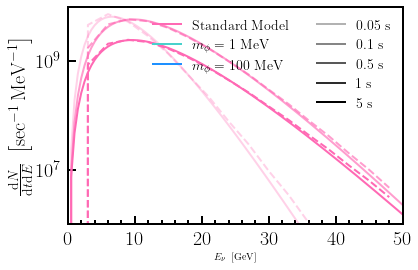

In [104]:
es = np.linspace(0, 200, 400) * units.MeV
ts = np.array([0.05, 0.1, 0.5]) * units["second"]
# ts = np.array([0.05, 0.1, 0.5, 1, 5]) * units["second"]

a = np.genfromtxt("../data/fluxactivenuE.csv", delimiter=",")
times = np.sort(np.unique(a[:, 0])) * units.second
energies = np.sort(np.unique(a[:, 1])) * units.MeV

alphamin = 0.3
alphamax = 1.0

handles = [
    Line2D([], [], color=COLORS[-1], label=r"Standard Model"),
    Line2D([], [], color=COLORS[0], label=r"$m_{\phi}=1~\mathrm{MeV}$"),
    # Line2D([], [], color=COLORS[1], label=r"$m_{\phi}=10~\mathrm{MeV}$"),
    Line2D([], [], color=COLORS[1], label=r"$m_{\phi}=100~\mathrm{MeV}$"),
    Line2D([], [], alpha=0.0),
    Line2D([], [], alpha=0.0),
    Line2D([], [], color="k", alpha=0/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.05}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=1/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=2/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.5}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=3/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=4/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{5}~\mathrm{s}$"),
]


for idx, t in enumerate(ts):
    alpha = idx / (len(ts)-1) * (alphamax - alphamin) + alphamin
    # for color, flux in zip(COLORS, bsm_fluxes):
    #     plt.plot(
    #         es / units.MeV,
    #         flux.get_flux(t, es, 0) * units.second * units.MeV,
    #         color=to_rgb(color) + (alpha,)
    #     )
    
    # Only plot the SM flux for the first 8 seconds
    if t > 8 * units.second:
        continue
    plt.plot(
        es / units.MeV,
        sm_flux.get_flux(t, es, 0) * units.second * units.MeV,
        color=to_rgb(COLORS[-1]) + (alpha,)   
    )
    
    idx = np.argmin(np.abs(times - t))
    print(idx)
    plt.plot(
        a[len(energies) * idx:len(energies) * (idx+1), 1],
        a[len(energies) * idx:len(energies) * (idx+1), 2],
        color=to_rgb(COLORS[-1]) + (alpha,),
        ls="--"
    )

       
plt.ylabel(
    r"$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}~\left[\mathrm{sec}^{-1}\,\mathrm{MeV}^{-1}\right]$",
    fontsize=20
)
plt.xlabel(
    r"$E_{\nu}~\left[\mathrm{GeV}\right]$"
)
plt.ylim(1e6, 1e10)
plt.xlim(0, 50)
plt.semilogy()
plt.legend(
    handles=handles,
    ncol=2,
    fontsize=14,
    framealpha=0.0,
    loc=1,
    # bbox_to_anchor=(1, 1.075)
)
plt.show()

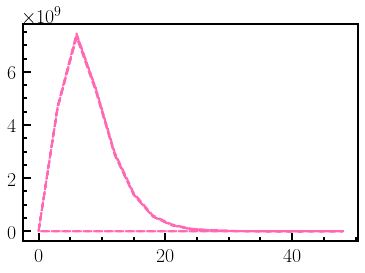

In [98]:
idx = 49
plt.plot(
        a[len(energies) * idx: (len(energies)+1) * idx, 1],
        a[len(energies) * idx: (len(energies)+1) * idx, 2],
        color=to_rgb(COLORS[-1]) + (alpha,),
        ls="--"
)

In [100]:
len(energies)

17

In [101]:
a[len(energies) * idx:len(energies) * (idx+1), 1]

array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36.,
       39., 42., 45., 48.])

In [81]:
a[len(energies) * idx: (len(energies)+1) * idx, 2]

array([0.00000000e+00, 4.16300589e+08, 6.93504542e+08, ...,
       3.84085468e+04, 1.40763167e+04, 0.00000000e+00])